<a href="https://colab.research.google.com/github/ncbx666/math_score_prediction/blob/main/math_score_regression_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import transforms, datasets
import kagglehub
import pandas as pd
from IPython.display import clear_output
import numpy as np
import seaborn as sns
# Download latest version
path = kagglehub.dataset_download("spscientist/students-performance-in-exams")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/spscientist/students-performance-in-exams/versions/1


In [3]:
df = pd.read_csv((f"{path}/StudentsPerformance.csv"))
df.head(20)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
5,female,group B,associate's degree,standard,none,71,83,78
6,female,group B,some college,standard,completed,88,95,92
7,male,group B,some college,free/reduced,none,40,43,39
8,male,group D,high school,free/reduced,completed,64,64,67
9,female,group B,high school,free/reduced,none,38,60,50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [5]:
df.nunique()

,0
gender,2
race/ethnicity,5
parental level of education,6
lunch,2
test preparation course,2
math score,81
reading score,72
writing score,77


Заменяем данные на более удобные для работы:

test preparation course на int64.

In [6]:
df['test preparation course'] = df['test preparation course'].map({"none": 0, "completed": 1})

Также с помощью LabelEcnoding заменим значение в столбце lunch:

Если у нас бесплатный ланч или удешевленный ланч, то заменим на 1, иначе 2

In [7]:
df['lunch'] = df['lunch'].map({"free/reduced": 1, "standard": 2})

Образование родителей тоже можно заменить с использованием энкодинга выше.

In [8]:
df['parental level of education'] = df['parental level of education'].map({
    "some high school": 1,
    "high school": 1.5,
    "some college": 2,
    "associate's degree": 2.5,
    "bachelor's degree": 3,
    "master's degree": 4
    })

In [9]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,3.0,2,0,72,72,74
1,female,group C,2.0,2,1,69,90,88
2,female,group B,4.0,2,0,90,95,93
3,male,group A,2.5,1,0,47,57,44
4,male,group C,2.0,2,0,76,78,75


Теперь разделяем данные с помощью OneHotEncoding, потому что оставшиеся данные нельзя сравнивать друг с другом.

In [10]:
df = pd.get_dummies(df, columns=['gender', 'race/ethnicity'], dtype=int)

In [11]:
df.head()

,parental level of education,lunch,test preparation course,math score,reading score,writing score,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E
0,3.0,2,0,72,72,74,1,0,0,1,0,0,0
1,2.0,2,1,69,90,88,1,0,0,0,1,0,0
2,4.0,2,0,90,95,93,1,0,0,1,0,0,0
3,2.5,1,0,47,57,44,0,1,1,0,0,0,0
4,2.0,2,0,76,78,75,0,1,0,0,1,0,0


Построим матрицу корреляции, чтобы посмотреть на зависимости в данных. Если понабится, сделаем feature engineering.

<Axes: >

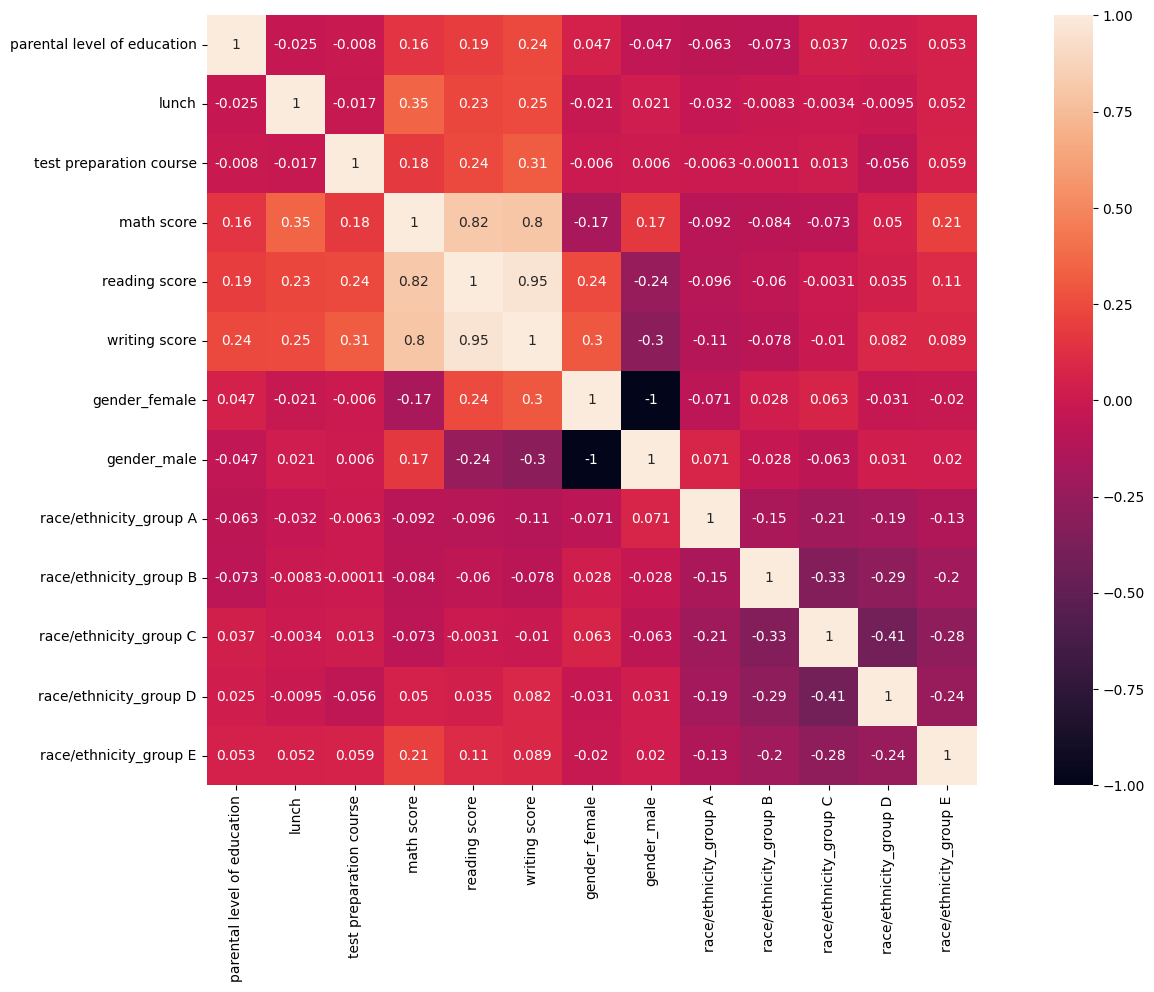

In [12]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(20,10))

sns.heatmap(corr_matrix, vmax=1, square=True, annot=True)

Выделяем целевую для нас переменную. В моем случае я захотел предсказать оценку по математике.

In [13]:
Y = df['math score']
df = df.drop(columns=['math score'])

Позже мы будем работать с фреймворком torch, поэтому сейчас переделываем все в тензоры.

In [14]:
data = torch.tensor(df.values, dtype=torch.float32)
Y = torch.tensor(Y.values, dtype=torch.float32)

Разделяем данные на тренировочные и тестовые, записей у нас не так много, поэтому 80% выделяем под тренировку.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data, Y, test_size = 0.2)

Создаем константы, которые не будут меняться на протяжении всего обучения

In [32]:
NUM_FEATURES = 12
NUM_EPOCH = 100000

NUM_OUT = 1

Для удобства использования делаем функцию для создания модели.
Модель довольно простая: всего три скрытых слоя.

Функция активации используется Relu

In [44]:
def create_model(hid_size1=32, n_features=NUM_FEATURES, n_out = NUM_OUT):

    model = nn.Sequential()
    model.add_module('l1', nn.Linear(n_features, hid_size1))
    model.add_module('activation1', nn.ReLU())
    model.add_module('l2', nn.Linear(hid_size1, n_out))

    return model

In [34]:
model = create_model()

Для удобства создаем функцию для тренировки модели. Так как задача регрессионная, то используем MSEloss.

Для подсчета функции ошибки сохраняем все значения функции потерь в отдельный массив.

In [35]:
def train_model(model, x_train, y_train):
  loss_function = nn.MSELoss()
  opt = torch.optim.SGD(model.parameters(), lr=0.00001)

  loss_history = []
  for num_of_epoch in range(NUM_EPOCH):
    opt.zero_grad()

    random_indices = np.random.choice(np.arange(len(x_train)), size=32)

    x_train_batch = x_train[random_indices]
    y_train_batch = y_train[random_indices]


    y_predicted = model(x_train_batch).view(-1)
    loss = loss_function(y_predicted, y_train_batch)

    loss.backward()
    opt.step()

    loss_history.append(loss.item())

  return model, loss_history

In [36]:
trained_model, loss = train_model(model, x_train, y_train)

Для проверки себя смотрю выводит ли для разных X разные предсказания

In [37]:
for i in range(2, 4):
  print(x_train[i].numpy())
  print(trained_model(x_train[i]).item())

[ 2.5  2.   1.  67.  73.   1.   0.   0.   0.   1.   0.   0. ]
60.15478515625
[ 2.  2.  0. 74. 76.  0.  1.  0.  0.  1.  0.  0.]
80.00990295410156


Считаем функцию ошибки

In [38]:
def calculate_mse(model, x_data, y_data):
    model.eval()  #перевели модель в режим оценки
    with torch.no_grad():  #отключаем вычисление градиентов
        y_predicted = model(x_data).view(-1)
        mse = F.mse_loss(y_predicted, y_data)
    return mse.item()


In [39]:
train_mse = calculate_mse(trained_model, x_train, y_train)
test_mse = calculate_mse(trained_model, x_test, y_test)

print(f"Training MSE: {train_mse}")
print(f"Testing MSE: {test_mse}")


Training MSE: 29.875001907348633
Testing MSE: 26.76482582092285


После подбора гипер параметров: размера батча, скорости обучения и количества слоев сети был получен результат примерно как у линейной регрессии.

In [40]:
for i in range(6, 10):
  print(f"predicted mark is {int(trained_model(x_test[i]).item())} and true mark is {int(y_test[i])}")

predicted mark is 50 and true mark is 52
predicted mark is 56 and true mark is 61
predicted mark is 90 and true mark is 97
predicted mark is 56 and true mark is 58


Посмотрим как справляется с такой же задачей линейная регрессия

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [42]:
lr_sklearn = LinearRegression().fit(x_train, y_train)
print('Final sklearn Linear Regression MSE on train data: {:.3f}'.format(
    mean_squared_error(lr_sklearn.predict(x_train), y_train)
))
print('Final sklearn Linear Regression MSE on test data: {:.3f}'.format(
    mean_squared_error(lr_sklearn.predict(x_test), y_test)
))

Final sklearn Linear Regression MSE on train data: 29.066
Final sklearn Linear Regression MSE on test data: 26.067


Строим график распределения погрешностей в зависимости от эпох обучения модели.

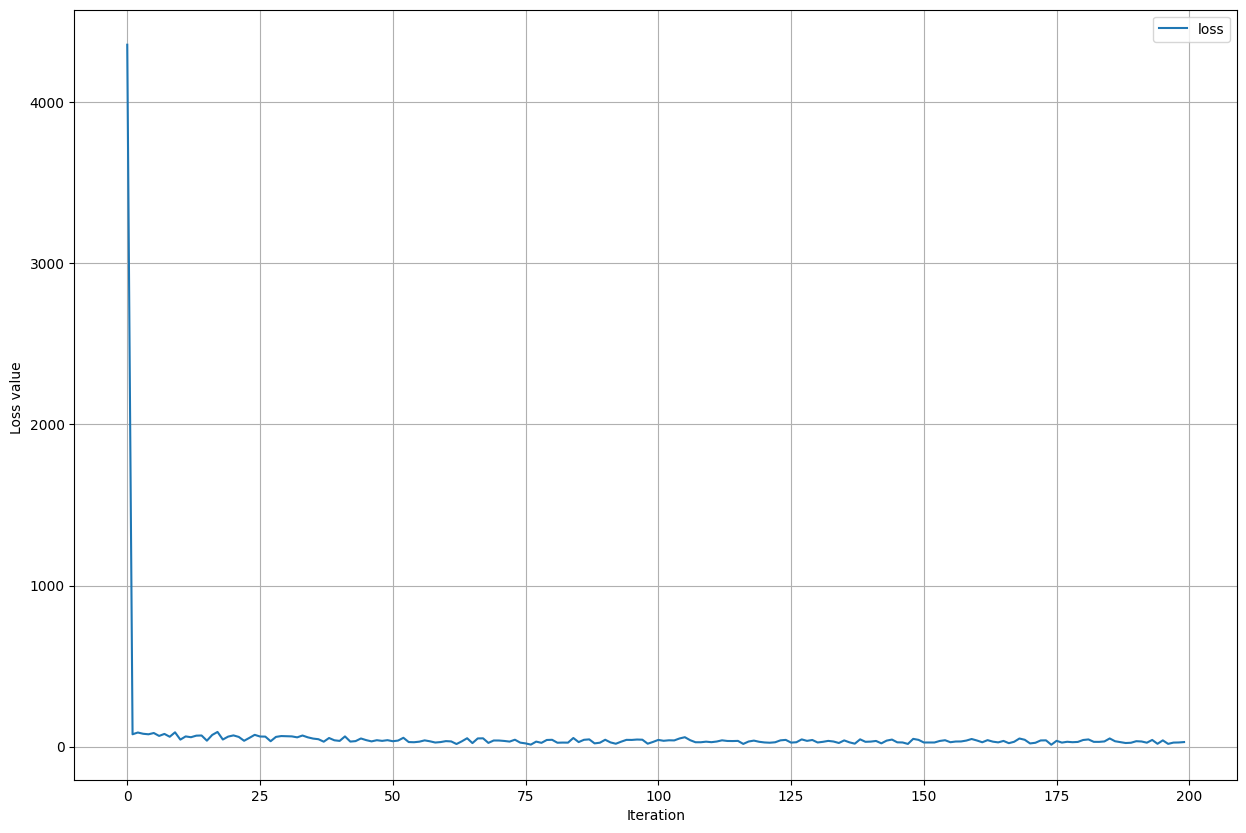

In [43]:
plot_history = []

for i in range(NUM_EPOCH):
    if i % 500 == 0:
        clear_output(True)
        plt.figure(figsize=(15, 10))
        plot_history.append(loss[i])  # добавляем текущее значение loss
        plt.plot(plot_history, label='loss')
        plt.grid()
        plt.xlabel('Iteration')
        plt.ylabel('Loss value ')
        plt.legend()
        plt.show()
